In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
 
from os.path import join as pjoin
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from importlib import reload
import cv2
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 10)
from matplotlib import pyplot as plt
%matplotlib inline

from utils import *
from dataset import *
from train import *

%load_ext autoreload
%autoreload 2
 
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
 
DATA_DIR = 'data/covers'
print(DATA_DIR)

In [3]:
import torch
from torch import nn
from unet_models import unet11
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

In [4]:
from pathlib import Path
from validation import validation_binary

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.backends.cudnn

In [5]:
# Get data
Img_files = {}
Mask_files = {}

Img_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'IMG*.png')))
Mask_files['all'] = sorted(glob.glob(pjoin(DATA_DIR, 'MASK*.png')))

train_ids = [580, 8, 4, 1, 39, 9, 12, 17, 2, 617, 568, 588, 159, 20, 13, 750, 3, 14, 22, 567, 10, 7, 21, 15, 11, 566,6]
val_ids = [18, 749, 16, 19, 519, 379, 5, 248]

Img_files['train'] = [file for file in Img_files['all'] if int(file[-8:-5]) in train_ids]
Mask_files['train'] = [file for file in Mask_files['all'] if int(file[-8:-5]) in train_ids]

Img_files['val'] = [file for file in Img_files['all'] if int(file[-8:-5]) in val_ids]
Mask_files['val'] = [file for file in Mask_files['all'] if int(file[-8:-5]) in val_ids]

TRAIN_SIZE = len(Img_files['train'])
VAL_SIZE = len(Img_files['val'])

In [6]:
train_dataset = TissuesDataset(Img_files['train'], 'train', mask_files=Mask_files['train'], augment=True)
val_dataset = TissuesDataset(Img_files['val'], 'val', mask_files=Mask_files['val'], augment=False)

Dataset 'train' loaded
	27 images
	27 masks
Dataset 'val' loaded
	8 images
	8 masks


### Check

In [7]:
# def to_np(img):
#     try:
#         return img.numpy().transpose(1,2,0)
#     except:
#         return img.numpy()

# for (img, mask) in train_dataset:
#     print(type(img), img.shape)
#     imshow(to_np(train_dataset.transforms.unnormalize(img)))
#     plt.show()
#     print(type(mask), mask.shape)
#     print(mask.unique())
#     maskshow(to_np(mask))
#     plt.show()

In [8]:
class Config():
    
    ROOT = 'runs'
    NUM_CLASSES = 1

    GPU = [0]
    BATCH_SIZE = 16
    NUM_WORKERS = 10
    LR = 2e-4
    NUM_EPOCHS = 100
    #LEAKY_RELU_COEF = 0.2
    
    JACCARD_WEIGHT = 0.5
    
    #WEIGHT_INIT_MEAN = 0
    #WEIGHT_INIT_STD = 0.02
    
    #ADAM_BETAS = (0.5, 0.999)


config = Config()

In [9]:
train_dataloader = DataLoader(train_dataset, config.BATCH_SIZE, shuffle=True,
                              num_workers=config.NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, config.BATCH_SIZE, shuffle=False,
                              num_workers=config.NUM_WORKERS)

### Train

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = unet11(pretrained=True)

if torch.cuda.is_available():
    if config.GPU:
        device_ids = config.GPU
    else:
        device_ids = None
    model = nn.DataParallel(model, device_ids=device_ids).cuda()

loss = LossBinary(jaccard_weight=config.JACCARD_WEIGHT)

In [12]:
cudnn.benchmark = True

In [13]:
valid = validation_binary

In [14]:
root = Path(config.ROOT)
root.mkdir(exist_ok=True, parents=True)

In [15]:
train(
    init_optimizer=lambda lr: Adam(model.parameters(), lr=lr),
    config=config,
    model=model,
    criterion=loss,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    validation=valid,
    fold=0,
    num_classes=config.NUM_CLASSES
)

Restored model, epoch 101, step 200


### Inference

In [18]:
val_dataset = TissuesDataset(Img_files['val'], 'val', mask_files=Mask_files['val'], augment=False)
val_dataloader = DataLoader(val_dataset, config.BATCH_SIZE, shuffle=False,
                              num_workers=config.NUM_WORKERS)
inputs, targets = val_dataset[0]
inputs, targets = inputs.unsqueeze_(0), targets.unsqueeze_(0)
with torch.no_grad():
    targets = cuda(targets)
print(inputs.shape, targets.shape)

Dataset 'val' loaded
	8 images
	8 masks
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])


In [24]:
targets_np = targets.cpu().detach().numpy()[0,0]
print(targets_np.shape)

targets_np = targets.cpu().detach().numpy()[0,0]
print(targets_np.shape)
maskshow(targets_np)
np.unique(targets_np)

In [23]:
outputs = model(inputs)
outputs_np = F.sigmoid(outputs).cpu().detach().numpy()[0,0]
maskshow(outputs_np)

In [21]:
float(loss(outputs, targets).cpu().detach().numpy())

0.09903369098901749

### Evaluate

#### Val dataset

In [53]:
def IoU(mask_gt, mask_pred):
    return (mask_gt * mask_pred).sum() / (np.maximum(mask_gt, mask_pred)).sum() * 100 

def Precision(mask_gt, mask_pred):
    return (mask_gt * mask_pred).sum() / mask_pred.sum() * 100 

def Recall(mask1, mask_pred):
    return (mask_gt * mask_pred).sum() / mask_gt.sum() * 100 

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 10)
ious = []
precisions = []
recalls = []
for img_file, mask_file in zip(Img_files['val'], Mask_files['val']):
    img, pads = load_image(img_file, pad=True)
    mask_gt = imread(mask_file, True)

    with torch.no_grad():
        input_img = torch.unsqueeze(img_transform(img).to(device), dim=0)

    with torch.no_grad():
        mask = F.sigmoid(model(input_img))

    mask_array = mask.data[0].cpu().numpy()[0]
    plt.subplot(1,3,1)
    imshow(img)
    plt.subplot(1,3,2)
    imshow(mask_array)
    
    mask_array = crop_image(mask_array, pads)
    image = crop_image(img, pads)
    mask_pred = (mask_array > 0.5).astype(np.uint8)
    plt.subplot(1,3,3)
    imshow(mask_overlay(image, mask_pred))
    plt.show()
    
    iou = IoU(mask_gt, mask_pred)
    ious.append(iou)
    print('IoU: {:.2f}%'.format(iou))
    precision = Precision(mask_gt, mask_pred)
    precisions.append(precision)
    print('Precision: {:.2f}%'.format(precision))
    recall = Recall(mask_gt, mask_pred)
    recalls.append(recall)
    print('Recall: {:.2f}%'.format(recall))

In [73]:
Ious = np.array(ious) / 100
Precisions = np.array(precisions) / 100
Recalls = np.array(recalls) / 100
print('\tMean IoU: {:.3f}\n\tMean precision: {:.3f}\n\tMean recall: {:.3f}'.format(Ious.mean(), Precisions.mean(), Recalls.mean()))

	Mean IoU: 0.788
	Mean precision: 0.869
	Mean recall: 0.908


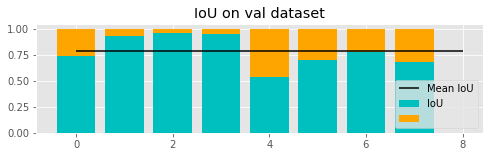

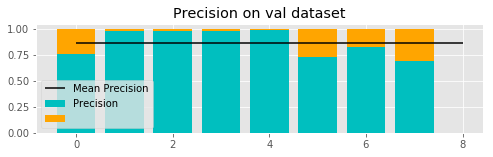

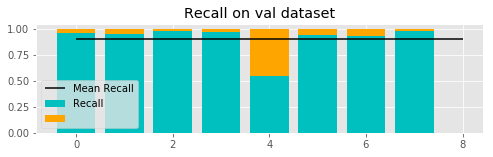

In [80]:
plt.style.use('ggplot')
mpl.rcParams["figure.figsize"] = (8, 2)
plot_ratio(Ious, 'IoU on val dataset', ['IoU', ''])
print('\tMean IoU: {:.3f}'.format(Ious.mean(), Precisions.mean(), Recalls.mean()))
plt.show()
plot_ratio(Precisions, 'Precision on val dataset', ['Precision', ''])
print('\tMean precision: {:.3f}'.format(Precisions.mean(), Recalls.mean()))
plt.show()
plot_ratio(Recalls, 'Recall on val dataset', ['Recall', ''])
print('\tMean recall: {:.3f}'.format(Recalls.mean()))
plt.show()

#### Train dataset (just for understanding)

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 10)
ious = []
for img_file, mask_file in zip(Img_files['train'], Mask_files['train']):
    img, pads = load_image(img_file, pad=True)
    mask_gt = imread(mask_file, True)

    with torch.no_grad():
        input_img = torch.unsqueeze(img_transform(img).to(device), dim=0)

    with torch.no_grad():
        mask = F.sigmoid(model(input_img))

    mask_array = mask.data[0].cpu().numpy()[0]
    plt.subplot(1,3,1)
    imshow(img)
    plt.subplot(1,3,2)
    imshow(mask_array)
    
    mask_array = crop_image(mask_array, pads)
    image = crop_image(img, pads)
    mask_pred = (mask_array > 0.5).astype(np.uint8)
    iou = IoU(mask_gt, mask_pred)
    ious.append(iou)
    print('IoU: {}'.format(iou))
    plt.subplot(1,3,3)
    imshow(mask_overlay(image, mask_pred))

    plt.show()

In [48]:
ious = np.array(ious) / 100
ious.mean()

0.8719942794237954

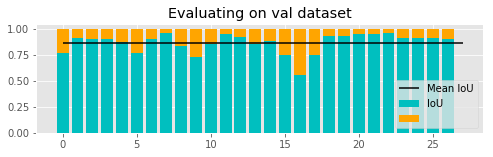

In [49]:
plt.style.use('ggplot')
mpl.rcParams["figure.figsize"] = (8, 2)
plot_ratio(ious, 'Evaluating on val dataset', ['IoU', ''])